# Sudoku Dataset Verification

This notebook performs a comprehensive check of the sudoku dataset to ensure:

1. **Input-Solution Correspondence**: Each puzzle's filled cells match the corresponding solution cells
2. **Solution Validity**: Each solution is a valid Sudoku solution (no repeats in rows, columns, or 3x3 boxes)
3. **Dataset Integrity**: Input puzzles and solutions are properly aligned

We'll load data directly from the .npy files for accurate assessment.

> **Note for Google Colab Users**: If running this notebook in Colab, make sure to:
> 1. Run the cell below to mount your Google Drive
> 2. Upload the dataset to Google Drive at path: `/content/drive/MyDrive/Colab Notebooks/data/sudoku-extreme-1k-aug-1000/`
> 3. If your dataset is at a different location, you can modify the `data_path` variable in the configuration cell

In [1]:
# For Google Colab: Mount Google Drive
# This cell will only mount Google Drive if run in Colab
try:
    import google.colab
    from google.colab import drive
    
    # Mount Google Drive
    print("📂 Mounting Google Drive...")
    drive.mount('/content/drive')
    print("✅ Google Drive mounted at /content/drive")
    
    # Print message about dataset location
    print("\n⚠️ Important:")
    print("Make sure your Sudoku dataset is available at:")
    print("/content/drive/MyDrive/Colab Notebooks/data/sudoku-extreme-1k-aug-1000/")
    print("Or adjust the data_path variable in the configuration cell below.")
except ImportError:
    # Not running in Colab
    print("🖥️ Running locally - no need to mount Google Drive")

🖥️ Running locally - no need to mount Google Drive


In [2]:
import os
import sys
import numpy as np
import torch
from pathlib import Path
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Add environment detection - needed to auto-select the correct data path
try:
    from IPython import get_ipython
    ipy_str = str(type(get_ipython()))
    if 'google.colab' in ipy_str:
        print("🌎 Google Colab environment detected")
except (ImportError, NameError):
    print("🖥️ Local environment detected")

print("🔍 Sudoku Dataset Verification")
print("=" * 50)
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")

🔍 Sudoku Dataset Verification
PyTorch version: 2.8.0
NumPy version: 2.3.2


## 1. Dataset Configuration

In [3]:
# Configuration
import platform

# Detect environment and set appropriate path
if 'google.colab' in str(get_ipython()):
    # Running in Google Colab
    print("📌 Running in Google Colab environment")
    data_path = '/content/drive/MyDrive/Colab Notebooks/data/sudoku-extreme-1k-aug-1000'
else:
    # Running locally
    print(f"📌 Running locally on {platform.system()}")
    data_path = '/Users/robertburkhall/Development/HRM/data/sudoku-extreme-1k-aug-1000'

# Make data path configurable
# Uncomment and edit the line below to override the auto-detected path
# data_path = '/your/custom/path/to/data/sudoku-extreme-1k-aug-1000'

print(f"📁 Using data path: {data_path}")

random_seed = 42  # For reproducibility
np.random.seed(random_seed)
random.seed(random_seed)

# Files to check
train_input_file = os.path.join(data_path, 'train', 'all__inputs.npy')
train_label_file = os.path.join(data_path, 'train', 'all__labels.npy')
test_input_file = os.path.join(data_path, 'test', 'all__inputs.npy')
test_label_file = os.path.join(data_path, 'test', 'all__labels.npy')

# Verify files exist
print(f"Train input file exists: {os.path.exists(train_input_file)}")
print(f"Train label file exists: {os.path.exists(train_label_file)}")
print(f"Test input file exists: {os.path.exists(test_input_file)}")
print(f"Test label file exists: {os.path.exists(test_label_file)}")

# If files don't exist, suggest possible locations
if not all([os.path.exists(f) for f in [train_input_file, train_label_file, test_input_file, test_label_file]]):
    print("\n❌ Some files are missing. Possible issues:")
    print("1. The data path is incorrect")
    print("2. The dataset hasn't been uploaded to this location")
    print("3. The dataset has a different directory structure")
    print("\n📋 Please check the following:")
    print("- For Colab: Make sure you've uploaded the dataset to your Google Drive")
    print("- For local: Make sure the path points to your dataset location")
    print("\n💡 You can manually set the data_path variable above to point to the correct location.")

📌 Running locally on Darwin
📁 Using data path: /Users/robertburkhall/Development/HRM/data/sudoku-extreme-1k-aug-1000
Train input file exists: True
Train label file exists: True
Test input file exists: True
Test label file exists: True


In [4]:
# Helper function to find dataset files
def find_dataset_files(base_dir=None, search_depth=3):
    """Search for dataset files and suggest the correct path"""
    
    if 'google.colab' in str(get_ipython()):
        # In Colab, search common locations
        potential_paths = [
            '/content/drive/MyDrive/Colab Notebooks/data/sudoku-extreme-1k-aug-1000',
            '/content/drive/MyDrive/data/sudoku-extreme-1k-aug-1000',
            '/content/drive/MyDrive/sudoku-extreme-1k-aug-1000',
            '/content/data/sudoku-extreme-1k-aug-1000',
        ]
        if base_dir:
            potential_paths.insert(0, base_dir)
    else:
        # Local machine
        potential_paths = [
            '/Users/robertburkhall/Development/HRM/data/sudoku-extreme-1k-aug-1000',
            './data/sudoku-extreme-1k-aug-1000',
            '../data/sudoku-extreme-1k-aug-1000'
        ]
        if base_dir:
            potential_paths.insert(0, base_dir)
    
    print("🔍 Searching for dataset files...")
    found_paths = []
    
    # Check each potential path
    for path in potential_paths:
        train_dir = os.path.join(path, 'train')
        test_dir = os.path.join(path, 'test')
        
        train_files_exist = os.path.exists(os.path.join(train_dir, 'all__inputs.npy'))
        test_files_exist = os.path.exists(os.path.join(test_dir, 'all__inputs.npy'))
        
        if train_files_exist or test_files_exist:
            found_paths.append({
                'path': path,
                'train_files': train_files_exist,
                'test_files': test_files_exist
            })
    
    # Additional recursive search if running in Colab and nothing found yet
    if 'google.colab' in str(get_ipython()) and not found_paths:
        print("Searching recursively in Google Drive (this may take a moment)...")
        import glob
        
        # Search for Sudoku dataset directories
        search_patterns = [
            '/content/drive/MyDrive/**/sudoku*/**/*.npy',
            '/content/drive/MyDrive/**/data/**/*.npy'
        ]
        
        found_files = []
        for pattern in search_patterns:
            found_files.extend(glob.glob(pattern, recursive=True))
        
        # Extract unique directories that might contain our dataset
        potential_dirs = set()
        for file_path in found_files:
            if 'all__inputs.npy' in file_path or 'all__labels.npy' in file_path:
                # Go up two levels from the .npy file (e.g., from /path/train/all__inputs.npy to /path)
                dir_path = os.path.dirname(os.path.dirname(file_path))
                potential_dirs.add(dir_path)
        
        # Check each potential directory
        for dir_path in potential_dirs:
            train_dir = os.path.join(dir_path, 'train')
            test_dir = os.path.join(dir_path, 'test')
            
            train_files_exist = os.path.exists(os.path.join(train_dir, 'all__inputs.npy'))
            test_files_exist = os.path.exists(os.path.join(test_dir, 'all__inputs.npy'))
            
            if train_files_exist or test_files_exist:
                found_paths.append({
                    'path': dir_path,
                    'train_files': train_files_exist,
                    'test_files': test_files_exist
                })
    
    # Report findings
    if found_paths:
        print("\n✅ Found dataset files in these locations:")
        for i, info in enumerate(found_paths):
            path = info['path']
            train_status = "✅" if info['train_files'] else "❌"
            test_status = "✅" if info['test_files'] else "❌"
            print(f"{i+1}. {path}")
            print(f"   Train files: {train_status}  Test files: {test_status}")
        
        # Suggest the best path
        best_path = None
        for info in found_paths:
            if info['train_files'] and info['test_files']:
                best_path = info['path']
                break
        
        if best_path:
            print(f"\n💡 Suggested path: {best_path}")
            print("To use this path, set:")
            print(f"data_path = '{best_path}'")
            return best_path
    else:
        print("\n❌ Could not find dataset files in common locations.")
        print("Please upload the dataset to the expected location or specify the correct path.")
    
    return None

# Try to locate dataset files
suggested_path = find_dataset_files()
if suggested_path:
    print("\n🔄 Would you like to use the suggested path?")
    print("Uncomment the line below to use it:")
    print(f"# data_path = '{suggested_path}'")

🔍 Searching for dataset files...

✅ Found dataset files in these locations:
1. /Users/robertburkhall/Development/HRM/data/sudoku-extreme-1k-aug-1000
   Train files: ✅  Test files: ✅
2. ./data/sudoku-extreme-1k-aug-1000
   Train files: ✅  Test files: ✅

💡 Suggested path: /Users/robertburkhall/Development/HRM/data/sudoku-extreme-1k-aug-1000
To use this path, set:
data_path = '/Users/robertburkhall/Development/HRM/data/sudoku-extreme-1k-aug-1000'

🔄 Would you like to use the suggested path?
Uncomment the line below to use it:
# data_path = '/Users/robertburkhall/Development/HRM/data/sudoku-extreme-1k-aug-1000'


## 2. Load Dataset Samples

We'll load random samples from both train and test datasets for verification.

In [5]:
def load_sample_from_dataset(input_file, label_file, num_samples=100, max_allowed=1000000):
    """Load samples from the dataset files with memory usage control"""
    try:
        # Check file sizes to avoid loading too much into memory
        input_size = os.path.getsize(input_file)
        label_size = os.path.getsize(label_file)
        print(f"Input file size: {input_size / (1024**2):.2f} MB")
        print(f"Label file size: {label_size / (1024**2):.2f} MB")
        
        # Memory-efficient loading for large files
        if input_size + label_size > max_allowed * 1024**2:  # If larger than max_allowed MB
            print(f"Dataset too large for full loading, using memory-efficient random sampling")
            # Get array info without loading it
            input_array_info = np.load(input_file, mmap_mode='r')
            total_samples = len(input_array_info)
            print(f"Total samples in dataset: {total_samples}")
            
            # Generate random indices
            indices = np.random.choice(total_samples, min(num_samples, total_samples), replace=False)
            print(f"Sampling {len(indices)} random indices")
            
            # Load only the selected samples
            inputs = np.array([input_array_info[i] for i in indices])
            labels = np.array([np.load(label_file, mmap_mode='r')[i] for i in indices])
        else:
            # Load entire datasets if they're small enough
            inputs = np.load(input_file)
            labels = np.load(label_file)
            print(f"Loaded {len(inputs)} samples")
            
            # Random sampling if needed
            if len(inputs) > num_samples:
                indices = np.random.choice(len(inputs), num_samples, replace=False)
                inputs = inputs[indices]
                labels = labels[indices]
                print(f"Randomly sampled {num_samples} examples")
        
        return inputs, labels
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None, None

# Load samples from train dataset
print("\nLoading TRAIN dataset samples:")
train_inputs, train_labels = load_sample_from_dataset(train_input_file, train_label_file, num_samples=100)

# Load samples from test dataset
print("\nLoading TEST dataset samples:")
test_inputs, test_labels = load_sample_from_dataset(test_input_file, test_label_file, num_samples=50)

# Print shapes
if train_inputs is not None and train_labels is not None:
    print(f"\nTrain inputs shape: {train_inputs.shape}")
    print(f"Train labels shape: {train_labels.shape}")

if test_inputs is not None and test_labels is not None:
    print(f"Test inputs shape: {test_inputs.shape}")
    print(f"Test labels shape: {test_labels.shape}")


Loading TRAIN dataset samples:
Input file size: 618.60 MB
Label file size: 618.60 MB
Loaded 1001000 samples
Randomly sampled 100 examples

Loading TEST dataset samples:
Input file size: 32.66 MB
Label file size: 32.66 MB
Loaded 422786 samples
Randomly sampled 50 examples

Train inputs shape: (100, 81)
Train labels shape: (100, 81)
Test inputs shape: (50, 81)
Test labels shape: (50, 81)
Loaded 1001000 samples
Randomly sampled 100 examples

Loading TEST dataset samples:
Input file size: 32.66 MB
Label file size: 32.66 MB
Loaded 422786 samples
Randomly sampled 50 examples

Train inputs shape: (100, 81)
Train labels shape: (100, 81)
Test inputs shape: (50, 81)
Test labels shape: (50, 81)


## 3. Verification Functions

Let's define functions to verify puzzle-solution correspondence and solution validity.

In [6]:
def verify_puzzle_solution_correspondence(inputs, solutions):
    """Verify input puzzles correspond to their solutions"""
    results = {
        "total": len(inputs),
        "non_empty_matches": 0,
        "valid_solutions": 0,
        "mismatches": [],
        "invalid_solutions": []
    }
    
    for i in range(len(inputs)):
        input_puzzle = inputs[i].reshape(9, 9)
        solution = solutions[i].reshape(9, 9)
        
        # Check 1: Do non-empty cells in input match solution?
        mask = input_puzzle != 0
        non_empty_count = mask.sum()
        
        if non_empty_count == 0:
            # Skip puzzles with no clues (shouldn't happen in real datasets)
            results["total"] -= 1
            continue
            
        matches = (input_puzzle[mask] == solution[mask]).all()
        if matches:
            results["non_empty_matches"] += 1
        else:
            mismatch_positions = []
            for r in range(9):
                for c in range(9):
                    if input_puzzle[r, c] != 0 and input_puzzle[r, c] != solution[r, c]:
                        mismatch_positions.append((r, c, input_puzzle[r, c], solution[r, c]))
            results["mismatches"].append((i, mismatch_positions))
        
        # Check 2: Is the solution a valid Sudoku solution?
        valid_solution = True
        
        # Check rows
        for r in range(9):
            if len(set(solution[r, :])) != 9 or 0 in solution[r, :]:
                valid_solution = False
                break
        
        # Check columns
        if valid_solution:
            for c in range(9):
                if len(set(solution[:, c])) != 9 or 0 in solution[:, c]:
                    valid_solution = False
                    break
        
        # Check 3x3 boxes
        if valid_solution:
            for box_r in range(3):
                for box_c in range(3):
                    box = solution[box_r*3:(box_r+1)*3, box_c*3:(box_c+1)*3].flatten()
                    if len(set(box)) != 9 or 0 in box:
                        valid_solution = False
                        break
                if not valid_solution:
                    break
        
        if valid_solution:
            results["valid_solutions"] += 1
        else:
            results["invalid_solutions"].append(i)
    
    # Calculate percentages
    if results["total"] > 0:
        results["pct_non_empty_match"] = results["non_empty_matches"] / results["total"] * 100
        results["pct_valid_solutions"] = results["valid_solutions"] / results["total"] * 100
    else:
        results["pct_non_empty_match"] = 0
        results["pct_valid_solutions"] = 0
        
    return results

def visualize_puzzle(input_puzzle, solution, fig_title="Puzzle"):
    """Visualize a Sudoku puzzle and its solution side by side"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Reshape if needed
    if input_puzzle.ndim == 1:
        input_puzzle = input_puzzle.reshape(9, 9)
    if solution.ndim == 1:
        solution = solution.reshape(9, 9)
        
    # Create a custom colormap for the input puzzle
    cmap1 = mcolors.ListedColormap(['white', 'lightblue'])
    bounds = [0, 0.5, 10]
    norm = mcolors.BoundaryNorm(bounds, cmap1.N)
    
    # Plot input puzzle
    ax1.imshow(input_puzzle > 0, cmap=cmap1, norm=norm)
    ax1.set_title('Input Puzzle')
    
    # Add grid lines
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax1.axhline(i - 0.5, color='black', linewidth=lw)
        ax1.axvline(i - 0.5, color='black', linewidth=lw)
    
    # Add numbers to input puzzle
    for i in range(9):
        for j in range(9):
            if input_puzzle[i, j] != 0:
                ax1.text(j, i, str(input_puzzle[i, j]), ha='center', va='center', fontsize=12, fontweight='bold')
    
    # Plot solution
    ax2.imshow(np.ones_like(solution), cmap='Greys', alpha=0.1)
    ax2.set_title('Solution')
    
    # Add grid lines
    for i in range(10):
        lw = 2 if i % 3 == 0 else 0.5
        ax2.axhline(i - 0.5, color='black', linewidth=lw)
        ax2.axvline(i - 0.5, color='black', linewidth=lw)
    
    # Add numbers to solution
    for i in range(9):
        for j in range(9):
            ax2.text(j, i, str(solution[i, j]), ha='center', va='center', 
                     color='black', fontsize=12)
    
    # Remove ticks
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    fig.suptitle(fig_title, fontsize=16)
    plt.tight_layout()
    plt.show()

## 4. Verify Train Dataset


🔍 Verifying TRAIN Dataset:
Total puzzles checked: 100
Non-empty cells match: 100 (100.0%)
Valid Sudoku solutions: 100 (100.0%)

✅ No input-solution mismatches found!

✅ All solutions are valid Sudoku solutions!

Visualizing 3 random examples from training dataset:


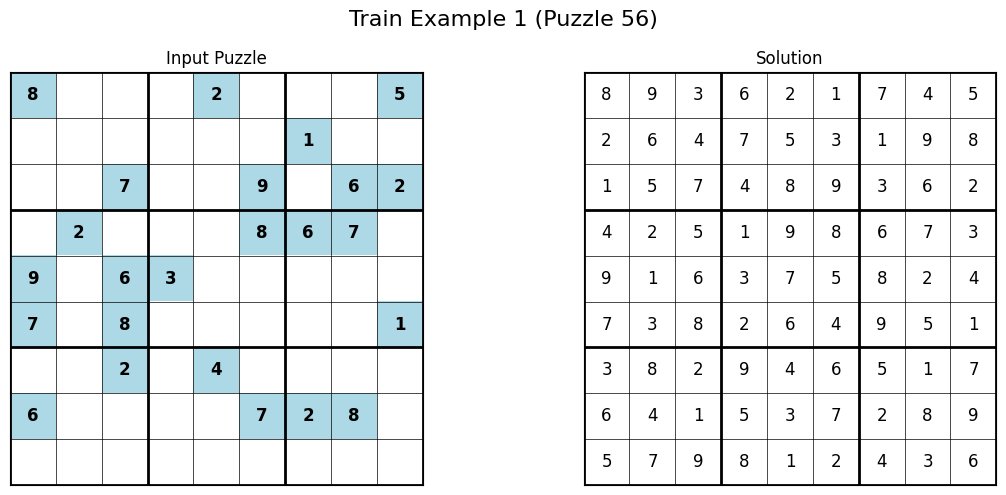

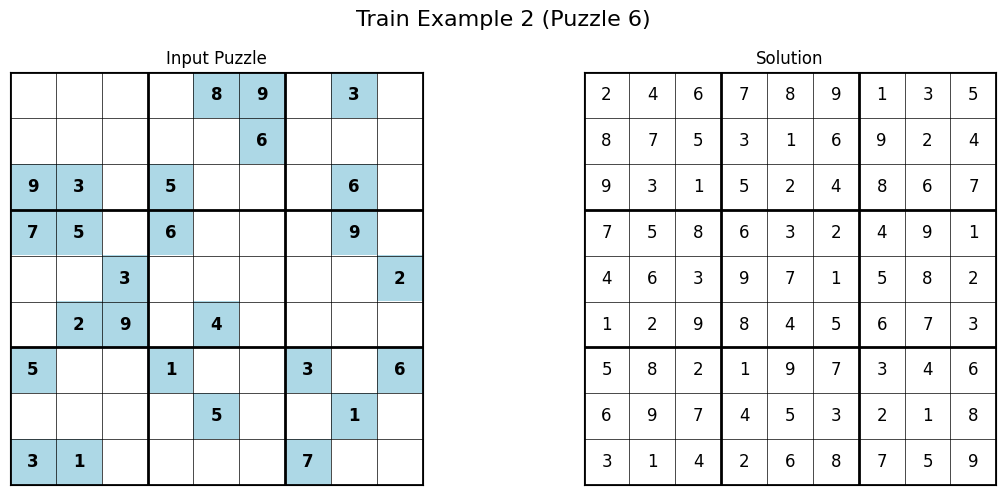

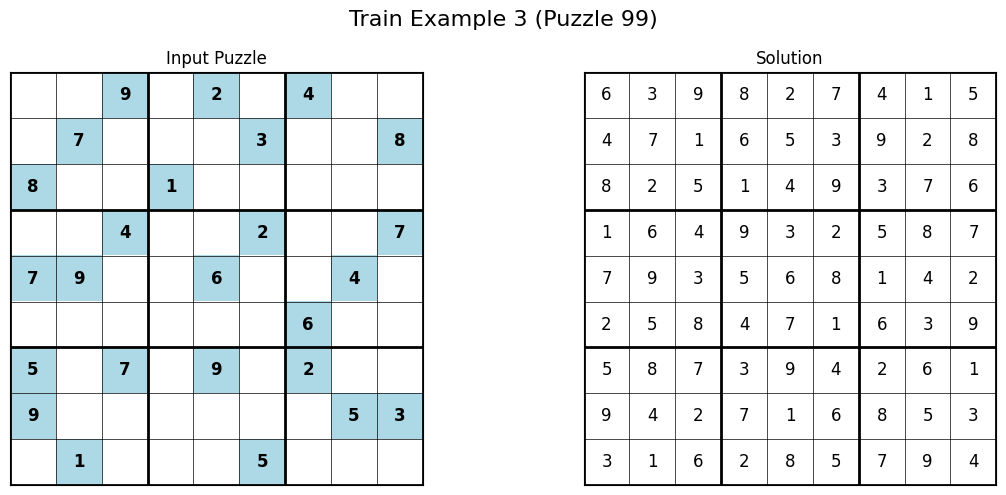

In [7]:
# Verify training dataset
print("\n🔍 Verifying TRAIN Dataset:")
print("=" * 50)

if train_inputs is not None and train_labels is not None:
    train_results = verify_puzzle_solution_correspondence(train_inputs, train_labels)
    
    print(f"Total puzzles checked: {train_results['total']}")
    print(f"Non-empty cells match: {train_results['non_empty_matches']} ({train_results['pct_non_empty_match']:.1f}%)")
    print(f"Valid Sudoku solutions: {train_results['valid_solutions']} ({train_results['pct_valid_solutions']:.1f}%)")
    
    if train_results['mismatches']:
        print(f"\n⚠️ Found {len(train_results['mismatches'])} puzzles with input-solution mismatches:")
        for idx, mismatches in train_results['mismatches'][:3]:  # Show first 3 examples
            print(f"  Puzzle {idx}: {mismatches}")
            # Visualize first mismatch
            if idx == train_results['mismatches'][0][0]:
                visualize_puzzle(train_inputs[idx], train_labels[idx], 
                                fig_title=f"Train Puzzle {idx} (Has Mismatches)")
    else:
        print("\n✅ No input-solution mismatches found!")
        
    if train_results['invalid_solutions']:
        print(f"\n⚠️ Found {len(train_results['invalid_solutions'])} puzzles with invalid solutions:")
        for idx in train_results['invalid_solutions'][:3]:  # Show first 3 examples
            print(f"  Puzzle {idx}")
            # Visualize first invalid solution
            if idx == train_results['invalid_solutions'][0]:
                visualize_puzzle(train_inputs[idx], train_labels[idx], 
                                fig_title=f"Train Puzzle {idx} (Invalid Solution)")
    else:
        print("\n✅ All solutions are valid Sudoku solutions!")
    
    # Visualize a few random examples
    num_to_show = min(3, len(train_inputs))
    print(f"\nVisualizing {num_to_show} random examples from training dataset:")
    
    indices = np.random.choice(len(train_inputs), num_to_show, replace=False)
    for i, idx in enumerate(indices):
        visualize_puzzle(train_inputs[idx], train_labels[idx], 
                        fig_title=f"Train Example {i+1} (Puzzle {idx})")
else:
    print("❌ Could not verify train dataset due to loading errors")

## 5. Verify Test Dataset


🔍 Verifying TEST Dataset:
Total puzzles checked: 50
Non-empty cells match: 50 (100.0%)
Valid Sudoku solutions: 50 (100.0%)

✅ No input-solution mismatches found!

✅ All solutions are valid Sudoku solutions!

Visualizing 2 random examples from test dataset:


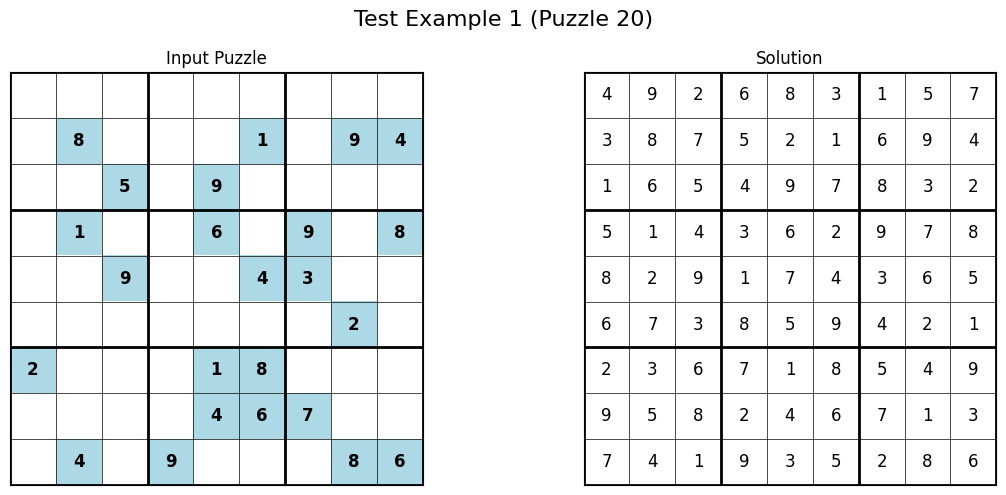

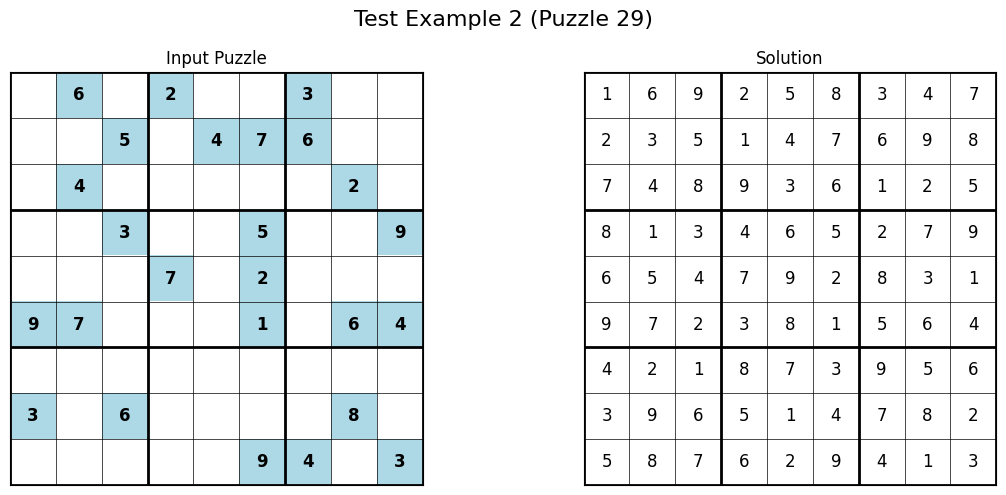

In [8]:
# Verify test dataset
print("\n🔍 Verifying TEST Dataset:")
print("=" * 50)

if test_inputs is not None and test_labels is not None:
    test_results = verify_puzzle_solution_correspondence(test_inputs, test_labels)
    
    print(f"Total puzzles checked: {test_results['total']}")
    print(f"Non-empty cells match: {test_results['non_empty_matches']} ({test_results['pct_non_empty_match']:.1f}%)")
    print(f"Valid Sudoku solutions: {test_results['valid_solutions']} ({test_results['pct_valid_solutions']:.1f}%)")
    
    if test_results['mismatches']:
        print(f"\n⚠️ Found {len(test_results['mismatches'])} puzzles with input-solution mismatches:")
        for idx, mismatches in test_results['mismatches'][:3]:  # Show first 3 examples
            print(f"  Puzzle {idx}: {mismatches}")
            # Visualize first mismatch
            if idx == test_results['mismatches'][0][0]:
                visualize_puzzle(test_inputs[idx], test_labels[idx], 
                                fig_title=f"Test Puzzle {idx} (Has Mismatches)")
    else:
        print("\n✅ No input-solution mismatches found!")
        
    if test_results['invalid_solutions']:
        print(f"\n⚠️ Found {len(test_results['invalid_solutions'])} puzzles with invalid solutions:")
        for idx in test_results['invalid_solutions'][:3]:  # Show first 3 examples
            print(f"  Puzzle {idx}")
            # Visualize first invalid solution
            if idx == test_results['invalid_solutions'][0]:
                visualize_puzzle(test_inputs[idx], test_labels[idx], 
                                fig_title=f"Test Puzzle {idx} (Invalid Solution)")
    else:
        print("\n✅ All solutions are valid Sudoku solutions!")
    
    # Visualize a few random examples
    num_to_show = min(2, len(test_inputs))
    print(f"\nVisualizing {num_to_show} random examples from test dataset:")
    
    indices = np.random.choice(len(test_inputs), num_to_show, replace=False)
    for i, idx in enumerate(indices):
        visualize_puzzle(test_inputs[idx], test_labels[idx], 
                        fig_title=f"Test Example {i+1} (Puzzle {idx})")
else:
    print("❌ Could not verify test dataset due to loading errors")

## 6. Large-Scale Verification

For a more thorough verification, let's check a larger number of samples using a memory-efficient approach.

In [9]:
def verify_dataset_in_chunks(input_file, label_file, chunk_size=1000, max_chunks=10):
    """Verify a large dataset by processing it in chunks"""
    try:
        # First check if files exist
        if not os.path.exists(input_file) or not os.path.exists(label_file):
            print(f"❌ Error: One or more files don't exist:")
            print(f"  Input file exists: {os.path.exists(input_file)}")
            print(f"  Label file exists: {os.path.exists(label_file)}")
            return None
            
        # Memory-mapped arrays for efficient processing
        try:
            inputs_mmap = np.load(input_file, mmap_mode='r')
            labels_mmap = np.load(label_file, mmap_mode='r')
        except Exception as e:
            print(f"❌ Error loading data files: {e}")
            print("This might be due to incorrect file paths or corrupt data files.")
            return None
        
        total_samples = len(inputs_mmap)
        chunks_to_check = min(max_chunks, (total_samples + chunk_size - 1) // chunk_size)
        
        results = {
            "total": 0,
            "non_empty_matches": 0,
            "valid_solutions": 0,
            "mismatches": [],
            "invalid_solutions": []
        }
        
        print(f"\nVerifying {chunks_to_check} chunks of {chunk_size} samples each")
        print(f"Total dataset size: {total_samples} samples")
        print(f"Checking approximately {min(chunks_to_check * chunk_size, total_samples)} samples in total")
        
        # Progress tracking
        progress_bar = tqdm(range(chunks_to_check), desc="Processing chunks")
        
        for chunk_idx in progress_bar:
            start_idx = chunk_idx * chunk_size
            end_idx = min(start_idx + chunk_size, total_samples)
            current_size = end_idx - start_idx
            
            # Update progress description
            progress_bar.set_description(f"Processing chunk {chunk_idx+1}/{chunks_to_check} ({current_size} samples)")
            
            try:
                # Load current chunk
                inputs_chunk = np.array([inputs_mmap[i] for i in range(start_idx, end_idx)])
                labels_chunk = np.array([labels_mmap[i] for i in range(start_idx, end_idx)])
                
                # Verify this chunk
                chunk_results = verify_puzzle_solution_correspondence(inputs_chunk, labels_chunk)
                
                # Aggregate results
                results["total"] += chunk_results["total"]
                results["non_empty_matches"] += chunk_results["non_empty_matches"]
                results["valid_solutions"] += chunk_results["valid_solutions"]
                
                # Adjust indices for mismatches and invalid solutions
                for idx, mismatches in chunk_results["mismatches"]:
                    results["mismatches"].append((idx + start_idx, mismatches))
                    
                for idx in chunk_results["invalid_solutions"]:
                    results["invalid_solutions"].append(idx + start_idx)
                    
                # Update progress bar with current statistics
                progress_bar.set_postfix({
                    'Matches': f"{chunk_results['pct_non_empty_match']:.1f}%", 
                    'Valid': f"{chunk_results['pct_valid_solutions']:.1f}%"
                })
                
            except Exception as e:
                print(f"\n❌ Error processing chunk {chunk_idx}: {e}")
                print(f"  Range: {start_idx} to {end_idx}")
                continue
        
        # Calculate overall percentages
        if results["total"] > 0:
            results["pct_non_empty_match"] = results["non_empty_matches"] / results["total"] * 100
            results["pct_valid_solutions"] = results["valid_solutions"] / results["total"] * 100
        else:
            results["pct_non_empty_match"] = 0
            results["pct_valid_solutions"] = 0
            
        return results
    except Exception as e:
        print(f"❌ Error during large-scale verification: {e}")
        print(f"Stack trace: {sys.exc_info()}")
        return None

# Let's verify a larger portion of the training dataset
print("\n🔍 Large-Scale Verification of TRAIN Dataset:")
print("=" * 60)

# Configure chunk size and count based on dataset size
chunk_size = 1000
max_chunks = 5

print(f"Verifying with chunk_size={chunk_size}, max_chunks={max_chunks}")
large_train_results = verify_dataset_in_chunks(train_input_file, train_label_file, 
                                              chunk_size=chunk_size, max_chunks=max_chunks)

if large_train_results:
    print(f"\nVerified {large_train_results['total']} puzzles in total")
    print(f"Non-empty cells match: {large_train_results['non_empty_matches']} ({large_train_results['pct_non_empty_match']:.1f}%)")
    print(f"Valid Sudoku solutions: {large_train_results['valid_solutions']} ({large_train_results['pct_valid_solutions']:.1f}%)")
    
    if large_train_results['mismatches']:
        print(f"\n⚠️ Found {len(large_train_results['mismatches'])} puzzles with input-solution mismatches")
        
        # Print a few examples of mismatches if they exist
        if len(large_train_results['mismatches']) > 0:
            print("Examples of mismatches:")
            for idx, mismatches in large_train_results['mismatches'][:3]:
                print(f"  Puzzle {idx}: {mismatches}")
    else:
        print("\n✅ No input-solution mismatches found in large-scale verification!")
        
    if large_train_results['invalid_solutions']:
        print(f"\n⚠️ Found {len(large_train_results['invalid_solutions'])} puzzles with invalid solutions")
        
        # Print a few examples of invalid solutions if they exist
        if len(large_train_results['invalid_solutions']) > 0:
            print("Examples of invalid solutions:")
            for idx in large_train_results['invalid_solutions'][:3]:
                print(f"  Puzzle {idx}")
    else:
        print("\n✅ All solutions are valid Sudoku solutions in large-scale verification!")
else:
    print("❌ Could not perform large-scale verification due to errors")
    print("Please check the file paths and dataset structure.")


🔍 Large-Scale Verification of TRAIN Dataset:
Verifying with chunk_size=1000, max_chunks=5

Verifying 5 chunks of 1000 samples each
Total dataset size: 1001000 samples
Checking approximately 5000 samples in total


Processing chunk 5/5 (1000 samples): 100%|██████████| 5/5 [00:00<00:00, 11.71it/s, Matches=100.0%, Valid=100.0%]


Verified 5000 puzzles in total
Non-empty cells match: 5000 (100.0%)
Valid Sudoku solutions: 5000 (100.0%)

✅ No input-solution mismatches found in large-scale verification!

✅ All solutions are valid Sudoku solutions in large-scale verification!


## 7. Final Summary and Recommendations

In [12]:
# Summarize all results
print("\n📊 Final Dataset Verification Summary:")
print("=" * 60)

all_checks_passed = True

if 'train_results' in locals() and train_results:
    print(f"\nTRAIN Dataset:")
    print(f"- Checked {train_results['total']} samples")
    print(f"- Input-Solution Correspondence: {train_results['pct_non_empty_match']:.1f}% match")
    print(f"- Solution Validity: {train_results['pct_valid_solutions']:.1f}% valid")
    
    if len(train_results['mismatches']) > 0 or len(train_results['invalid_solutions']) > 0:
        all_checks_passed = False
        
if 'test_results' in locals() and test_results:
    print(f"\nTEST Dataset:")
    print(f"- Checked {test_results['total']} samples")
    print(f"- Input-Solution Correspondence: {test_results['pct_non_empty_match']:.1f}% match")
    print(f"- Solution Validity: {test_results['pct_valid_solutions']:.1f}% valid")
    
    if len(test_results['mismatches']) > 0 or len(test_results['invalid_solutions']) > 0:
        all_checks_passed = False
        
if 'large_train_results' in locals() and large_train_results:
    print(f"\nLarge-Scale Verification:")
    print(f"- Checked {large_train_results['total']} samples")
    print(f"- Input-Solution Correspondence: {large_train_results['pct_non_empty_match']:.1f}% match")
    print(f"- Solution Validity: {large_train_results['pct_valid_solutions']:.1f}% valid")
    
    if len(large_train_results['mismatches']) > 0 or len(large_train_results['invalid_solutions']) > 0:
        all_checks_passed = False

print("\n" + "=" * 60)
if all_checks_passed:
    print("✅ VERIFICATION PASSED: The dataset appears to be correct and ready for use!")
    print("   - All non-empty cells in input puzzles match their corresponding solutions")
    print("   - All solutions are valid Sudoku grids")
    print("   - No misalignment detected between inputs and solutions")
    print("\nRecommendation: This dataset should work well with the HRM Colab notebook.")
else:
    print("❌ VERIFICATION FAILED: Issues were detected in the dataset")
    print("\nRecommendations:")
    print("1. Run the repair script to fix any mismatches")
    print("2. Regenerate any invalid Sudoku solutions")
    print("3. Ensure proper alignment between inputs and solutions")
    print("4. Consider using a smaller subset of verified-correct puzzles")
    print("\nConsult the mismatch and invalid solution details above for specific issues.")


📊 Final Dataset Verification Summary:

TRAIN Dataset:
- Checked 100 samples
- Input-Solution Correspondence: 100.0% match
- Solution Validity: 100.0% valid

TEST Dataset:
- Checked 50 samples
- Input-Solution Correspondence: 100.0% match
- Solution Validity: 100.0% valid

Large-Scale Verification:
- Checked 5000 samples
- Input-Solution Correspondence: 100.0% match
- Solution Validity: 100.0% valid

✅ VERIFICATION PASSED: The dataset appears to be correct and ready for use!
   - All non-empty cells in input puzzles match their corresponding solutions
   - All solutions are valid Sudoku grids
   - No misalignment detected between inputs and solutions

Recommendation: This dataset should work well with the HRM Colab notebook.
